In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('ecommerce_2025.csv') 

In [3]:
data

,Order_Date,Time,Age,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Revenue,Shipping_Cost,Order_Priority,Payment_method,MKTG_Channel,Marketing_Spend
0,2018-01-02,10:56:33,36,37077,1,1,Member,Auto & Accessories,Car Media Players,140.0,4.6,Medium,credit_card,Email,16.10
1,2018-07-24,20:41:37,54,59173,1,1,Member,Auto & Accessories,Car Speakers,211.0,11.2,Medium,credit_card,Email,41.53
2,2018-11-08,08:38:49,32,41066,1,1,Member,Auto & Accessories,Car Body Covers,117.0,3.1,Critical,credit_card,Social,45.74
3,2018-04-18,19:28:06,43,50741,1,1,Member,Auto & Accessories,Car & Bike Care,118.0,2.6,High,credit_card,Paid Search,94.25
4,2018-08-13,21:18:39,48,53639,1,1,Member,Auto & Accessories,Tyre,250.0,16.0,Critical,credit_card,YouTube,34.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51278,2018-02-28,22:59:50,19,78489,1,0,Member,Home & Furniture,Shoe Rack,124.0,1.9,Medium,money_order,Paid Search,61.39
51279,2018-02-28,13:19:25,40,91941,1,0,Member,Home & Furniture,Umbrellas,70.0,1.4,Medium,credit_card,Email,22.62
51280,2018-02-28,10:25:07,24,63313,0,1,Member,Home & Furniture,Dinner Crockery,133.0,4.0,Medium,credit_card,Email,21.06
51281,2018-02-28,10:50:08,47,86485,0,1,Member,Home & Furniture,Sofa Covers,216.0,13.2,Medium,credit_card,Paid Search,62.12


In [4]:
unique_customers = data['Customer_Id'].unique()


In [5]:
# Display the number of unique customers and sample values
print(f"Total Unique Customers: {len(unique_customers)}")

Total Unique Customers: 38990


In [6]:
customer_orders = data.groupby('Customer_Id')['Order_Date'].count().sort_values(ascending=False).reset_index().rename(columns={'Order_Date': 'Number_of_Orders'})
customer_orders

,Customer_Id,Number_of_Orders
0,95831,6
1,75238,5
2,87539,5
3,87989,5
4,96468,5
...,...,...
38985,46806,1
38986,46802,1
38987,46794,1
38988,46787,1


In [7]:
customer_revenue_sum = data.groupby('Customer_Id')['Revenue'].sum().sort_values(ascending=False).reset_index()
customer_revenue_sum

,Customer_Id,Revenue
0,87989,994.0
1,35324,949.0
2,79016,935.0
3,10436,929.0
4,51093,927.0
...,...,...
38985,47255,33.0
38986,47272,33.0
38987,35687,33.0
38988,26593,33.0


In [8]:
customer_revenue_avg = data.groupby('Customer_Id')['Revenue'].mean().sort_values(ascending=False).reset_index()
customer_revenue_avg

,Customer_Id,Revenue
0,43679,250.0
1,33211,250.0
2,41046,250.0
3,11999,250.0
4,25404,250.0
...,...,...
38985,56872,33.0
38986,11080,33.0
38987,11397,33.0
38988,20798,33.0


In [9]:
# Selecting relevant features for segmentation
segmentation_data = data.groupby('Customer_Id').agg({
    'Order_Date': 'count',  # Number of orders
    'Age': 'mean',          # Average age
    'Revenue': 'sum',       # Total revenue spent
    'Shipping_Cost': 'sum', # Total shipping cost paid
    'Marketing_Spend': 'sum' # Total marketing spend exposure
}).rename(columns={'Order_Date': 'Number_of_Orders'}).reset_index()

# Drop Customer_Id for clustering (can be used later for mapping)
customer_ids = segmentation_data['Customer_Id']
segmentation_data = segmentation_data.drop(columns=['Customer_Id'])

print(segmentation_data.head())  

   Number_of_Orders   Age  Revenue  Shipping_Cost  Marketing_Spend
0                 2  57.5    293.0           16.7            60.33
1                 1  22.0    149.0            6.6            13.49
2                 1  61.0     85.0            0.2            89.57
3                 2  37.5    440.0           26.9            81.91
4                 1  33.0    159.0            7.4            29.02


In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(segmentation_data)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=segmentation_data.columns)

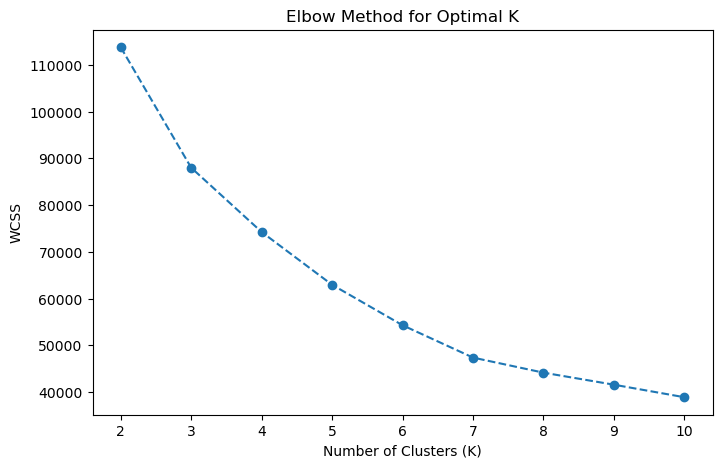

In [11]:
wcss = []  # Within-cluster sum of squares

for k in range(2, 11):  # Trying different cluster numbers
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)  # Store WCSS for each K

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

In [18]:
# Choose the best K based on the elbow method
optimal_k = 5  # Example: Adjust based on elbow curve

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
segmentation_data['Cluster'] = kmeans.fit_predict(scaled_df)

# Add Customer IDs back
segmentation_data['Customer_Id'] = customer_ids

print(segmentation_data.head())

   Number_of_Orders   Age  Revenue  Shipping_Cost  Marketing_Spend  Cluster  \
0                 2  57.5    293.0           16.7            60.33        0   
1                 1  22.0    149.0            6.6            13.49        1   
2                 1  61.0     85.0            0.2            89.57        3   
3                 2  37.5    440.0           26.9            81.91        4   
4                 1  33.0    159.0            7.4            29.02        1   

   Customer_Id  
0        10000  
1        10002  
2        10004  
3        10006  
4        10013  


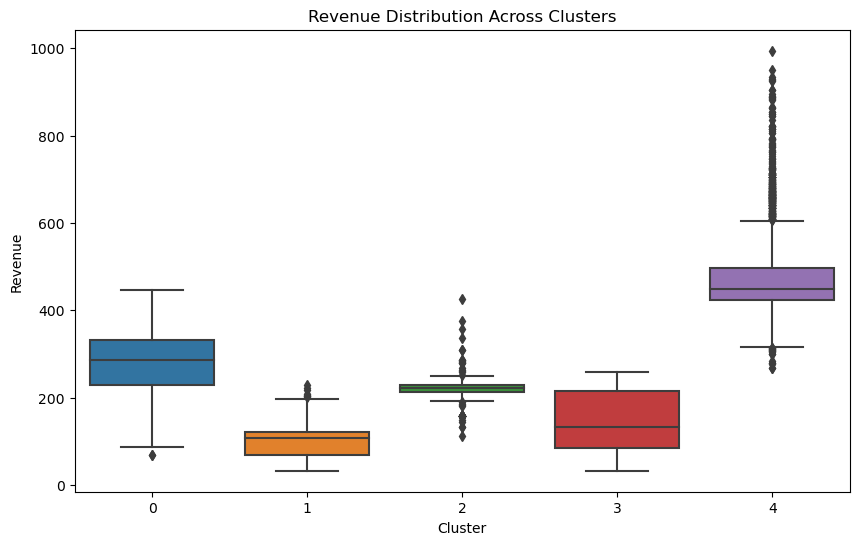

         Number_of_Orders        Age     Revenue  Shipping_Cost  \
Cluster                                                           
0                2.042258  41.221078  276.204882      11.749092   
1                1.015905  31.180469   98.418089       3.007921   
2                1.005469  32.708427  222.296669      12.288702   
3                1.015189  55.669724  149.553546       6.698123   
4                2.571164  41.741211  473.103736      24.185705   

         Marketing_Spend   Customer_Id  
Cluster                                 
0             100.629739  60722.586423  
1              49.886509  58091.301559  
2              49.086831  54175.474024  
3              49.711527  56281.474102  
4             130.558987  58963.004631  


In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Revenue', data=segmentation_data)
plt.title("Revenue Distribution Across Clusters")
plt.show()

# Summary stats per cluster
print(segmentation_data.groupby('Cluster').mean())

# Interpretation of Customer Segments (K=5 Clusters)

Based on the **elbow method**, customers are segmented into five groups based on **order behavior, age, revenue, shipping cost, and marketing spend**.

## Cluster 0: Mid-Value Frequent Buyers
- **Average Orders:** 2.04 (above average)  
- **Age:** 41.2 years  
- **Revenue per customer:** $276.20  

- **Shipping Cost:** $11.75  

- **Marketing Spend:** $100.63  

- **Interpretation:** Middle-aged customers who buy **frequently**, generating **mid-range revenue**. Moderate marketing spend suggests they respond to promotions.

## Cluster 1: Low-Value, Young Occasional Buyers
- **Average Orders:** 1.02 (low)  
- **Age:** 31.2 years (youngest)  
- **Revenue per customer:** $98.42 (lowest)  

- **Shipping Cost:** $3.00 (lowest)  

- **Marketing Spend:** $49.89 (lowest)  

- **Interpretation:** Young, infrequent buyers with **low engagement**. Consider **upselling or bundling** to increase purchase value.

## Cluster 2: High-Margin but Occasional Buyers
- **Average Orders:** 1.01  
- **Age:** 32.7 years  
- **Revenue per customer:** $222.30  

- **Shipping Cost:** $12.29 (high)  

- **Marketing Spend:** $49.08  

- **Interpretation:** **High-revenue per transaction** but **low order frequency**. Likely purchasing **premium or bulk** products.

## Cluster 3: Older, Medium Spenders
- **Average Orders:** 1.02  
- **Age:** 55.7 years (oldest)  
- **Revenue per customer:** $149.55  

- **Shipping Cost:** $6.70  

- **Marketing Spend:** $49.71  

- **Interpretation:** Older customers with **moderate revenue generation**, likely **necessity-based buyers**.

## Cluster 4: High-Value Frequent Buyers
- **Average Orders:** 2.57 (highest)  
- **Age:** 41.7 years  
- **Revenue per customer:** $473.10 (highest)  

- **Shipping Cost:** $24.19 (highest)  

- **Marketing Spend:** $130.56 (highest)  

- **Interpretation:** **Most valuable customers**. Frequent buyers who **generate high revenue**. Prioritize **retention, loyalty programs, and personalized offers**.